# Microtask 3 (Implementing CHAOSS metrics with Perceval idea)
By: José Alberto Marcial Sánchez

## Table of contents
<ol>
    <li><a href=#objective>Objective</a></li>
    <li><a href=#retrieving>Retrieving the data</a></li>
    <li><a href=#cleaning>Cleaning the data</a></li>
    <li><a href=#loading>Loading the issue's relevant information to a pandas dataframe</a></li>
    <li><a href=#selecting>Selecting rows from issues which were created and closed in the last year</a></li>
    <li><a href=#plottingall>Plotting the distribution of all issue's time to close</a></li>
    <li>Times to close distribution for individual repositories
        <ul>
            <li><a href = "#perceval">Perceval repo</a></li>
            <li><a href = "#sortinghat">SortingHat repo</a></li>
            <li><a href = "#kibiter">Kibiter repo</a></li>
        </ul>
    </li>
    <li><a href=#conclusions>Conclusions</a></li>
 <ol>

<h2><a id="objective" style="color:black;">Objective</a></h2>

<p>Produce a notebook with charts showing the distribution of time-to-close for issues already closed, and opened during the last year, for each of the repositories analyzed, and for all of them together. Use Pandas for this, and the Python charting library of your choice (as long as it is a FOSS module).</p>

<h2><a id="retrieving" style="color:black;">Retrieving the data</a></h2>

<p> For this task, information from the following GitHub repos will be analyzed:</p>
<ul>
    <li>Perceval (https://github.com/chaoss/grimoirelab-perceval)</li>
    <li>SortingHat (https://github.com/chaoss/grimoirelab-sortinghat)</li>
    <li>Kibiter (https://github.com/chaoss/grimoirelab-kibiter)</li>
</ul>

### Date of retrieval: April 3rd 2019

<p> The following commands were executed on terminal to write the retrieved data to the issues.json file:
    (XXXX after the -t should be replaced with a valid <a href = "https://help.github.com/en/articles/creating-a-personal-access-token-for-the-command-line">GitHub API Token</a>)
</p>

````
perceval github --json-line --category issue grimoirelab perceval --sleep-for-rate -t XXXX > issues.json 

perceval github --json-line --category issue grimoirelab sortinghat --sleep-for-rate -t XXXX >> issues.json 

perceval github --json-line --category issue grimoirelab kibiter --sleep-for-rate -t XXXX >> issues.json 
````



<h2><a id="cleaning" style="color:black;">Cleaning the data</a></h2>

<p>As <a href = "https://chaoss.github.io/grimoirelab-tutorial/perceval/github.html#retrieving-from-github-with-no-credentials">Perceval documentation</a> indicates, "in GitHub every pull request is an issue, but not every issue is a pull request. Thus, the issues returned may contain pull request information (included in the field pull_request within the issue)."
<p>
<p> So the next step is just selecting those issues with no "pull_request" inside the issue 'data' field </p>

In [22]:
##to avoid seeing warnings in the notebook
import warnings
warnings.filterwarnings('ignore')

## Importing the necessary libraries for the analysis and data manipulation

import json
import datetime
from dateutil import parser
import pandas as pd

##plotting libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
#creating a list of issues which are not pull requests
clean_issues = []
with open('issues.json') as issues_file:
    for line in issues_file:
        issue = json.loads(line)
        ##if theres no pull_request field, it means is a real issue, so we will add it to our issues list
        if ('pull_request' not in issue['data']):
            clean_issues.append(issue)
            

<h2><a id = "loading" style="color:black;">Loading the issue's relevant information to a pandas dataframe</a></h2>

<p> The next step is to create a pandas dataframe with every single element in clean_issues as a row of it. In order to achieve this, we are going to create a function called summarizeIssue which will take only relevant features(each of these will be a dataframe's column) for the analysis from each issue </p>

In [25]:
## Function based on the _summary function from the Code_changes class in the microstask 0 example

def summarizeIssue(issue):
    '''
    This is a function for summarizing issue's relevant information 
    
    Parameters:
    issue(dict) : json's file line describing an issue
    
    Returns:
    dict: A non-nested dictionary which can be easily appended as a row of a dataframe
    '''
    cdata = issue['data']
    
    ##Adding just the relevant fields from the complete issue
    summary = {
            'repo': issue['origin'],
            'uuid': issue['uuid'],
            'author': cdata['user']['login'],
            'created_date': datetime.datetime.strptime(cdata['created_at'],
                                           "%Y-%m-%dT%H:%M:%SZ"),
            'closed_date':datetime.datetime.strptime(cdata['closed_at'],
                                         "%Y-%m-%dT%H:%M:%SZ") if cdata['closed_at'] else None, 
            'url': cdata['html_url'],
            'state':cdata['state']
    }
    return summary

<p> The summarizeIssue function will help us to retrieve only important information from each issue </p>

In [26]:
##Creating the pandas dataframe
col_names = ['repo', 'uuid', 'author', 'created_date', 'closed_date', 'url','state' ]
issues_df = pd.DataFrame(columns = col_names)

##adding each issue from the clean_issues list to the issues_df dataframe
for issue in clean_issues:
    summary = summarizeIssue(issue)
    issues_df = issues_df.append(pd.Series(summary), ignore_index = True)

<h2><a id="selecting" style="color:black;">Selecting rows from issues which were created and closed in the last year</a></h2>

<p> Since we are going to analyze the distribution of time to close for issues already closed and opened during the last year, we just want to keep in our dataframe the issues which have a 'closed' state and whose create and closed date have 2018 in the year part </p>

In [27]:
##Retrieving issues dataframe columns datatypes
issues_df.dtypes

repo                    object
uuid                    object
author                  object
created_date    datetime64[ns]
closed_date             object
url                     object
state                   object
dtype: object

<p> As we see, first we will need to change the closed_date column to datetime type so we can be able to manipulate this attribute as a date </p>

In [28]:
##Setting the datatype of closed_date column to datetime
issues_df['closed_date'] = pd.to_datetime(issues_df['closed_date'])
issues_df.dtypes

repo                    object
uuid                    object
author                  object
created_date    datetime64[ns]
closed_date     datetime64[ns]
url                     object
state                   object
dtype: object

<p> Now lets select the registers to be analyzed. Remember, we just want issues opened and closed last year</p>

In [29]:
last_year = datetime.datetime.now().year - 1

#selecting issues opened and closed the last year

last_year_closed_issues = issues_df[(issues_df['created_date'].dt.year == last_year) & (issues_df['closed_date'].dt.year == last_year) & (issues_df['state'] == 'closed')]

<p> Let's see how many registers we got from our filtering </p>

In [30]:
last_year_closed_issues.shape

(55, 7)

The next step is calculating the days passed between `created_date` and `closed_date`, we achieve this by just substracting the `created_date` column from the `closed_date` one. We are assigning this to the this is `times_to_close` variable

In [31]:
last_year_closed_issues['time_to_close'] = (last_year_closed_issues['closed_date'] - last_year_closed_issues['created_date']).dt.days
time_to_close = last_year_closed_issues['time_to_close']

<h2><a id="plottingall" style="color:black;">Plotting the distribution of all issue's time to close</a></h2>

It's time to plot our `times_to_close` variable as a histogram, kernel density estimation and as a boxplot in order to see it's distribution. To do the plots, we will be using the <a href= "https://seaborn.pydata.org/">seaborn library </a>

Text(0.5, 1.0, "Combined repos' Days to Close Boxplot")

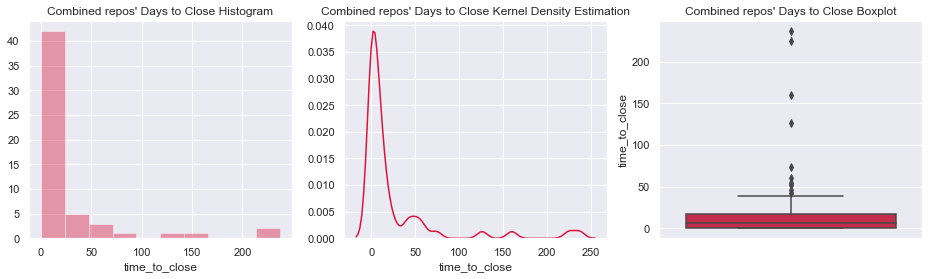

In [32]:
##creating figure with 3 columns in it
fig, axs = plt.subplots(ncols=3, figsize = (16,4))
##specifying first column content
sns.distplot(time_to_close, bins = 10, kde = False, color='crimson',ax=axs[0])
##specifying second column content(Kernel Density Estimation)
sns.distplot(time_to_close, hist = False, color='crimson',ax=axs[1])
##specifying third column content(boxplot)
sns.boxplot(time_to_close,ax=axs[2],orient = "v", color = "crimson")

##Setting plots' titles
axs[0].set_title("Combined repos' Days to Close Histogram")
axs[1].set_title("Combined repos' Days to Close Kernel Density Estimation")
axs[2].set_title("Combined repos' Days to Close Boxplot")

The histogram is showing that approximately 42 out of the 55 issues raised, were solved somewhere between 0 and 25 days. The KDE(kernel density estimation) is showing that the distribution is skewed to the right. The boxplot is showing that almost 100% of issues were solved somewhere between 0 and 45 days approximately, so the ones with a time to close greater than that can be considered as atypical records.

<h2><a id = "timesind" style="color:black;">Times to close distribution for individual repositories</a></h2>

In the `last_year_closed_issues`variable we already stored every issue created and closed in the last year (from the 3 repos). For the purposes of analyzing individual repositories we are just going to filter this dataframe by it's `url` field

<h3><a id="perceval" style="color:black;">Perceval repo</a></h3>

In [33]:
##selecting just perceval's issues
perceval_issues = last_year_closed_issues[last_year_closed_issues['repo'] == 'https://github.com/grimoirelab/perceval']
perceval_times_to_close = perceval_issues['time_to_close']

Let's see how many issues were created for perceval in the last year

In [34]:
perceval_issues.shape

(32, 8)

Text(0.5, 1.0, "Perceval's Days to Close Boxplot")

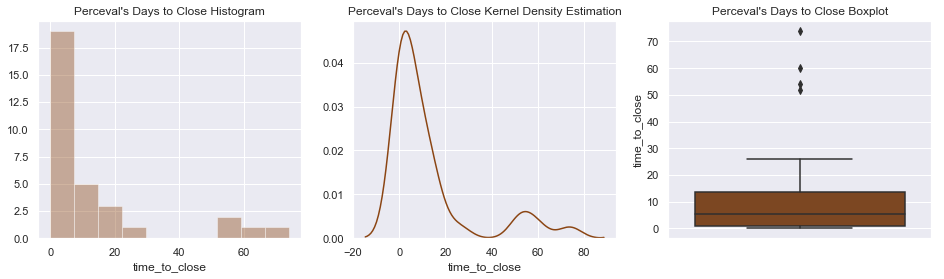

In [35]:
##creating figure with 3 columns in it
fig, axs = plt.subplots(ncols=3, figsize = (16,4))
##specifying first column content(histogram)
sns.distplot(perceval_times_to_close, bins = 10, kde = False, color='saddlebrown',ax=axs[0])
##specifying second column content(Kernel Density Estimation)
sns.distplot(perceval_times_to_close, hist = False, color='saddlebrown',ax=axs[1])
##specifying third column content(boxplot)
sns.boxplot(perceval_times_to_close,ax=axs[2],orient = "v", color = 'saddlebrown')

##Setting plots' titles
axs[0].set_title("Perceval's Days to Close Histogram")
axs[1].set_title("Perceval's Days to Close Kernel Density Estimation")
axs[2].set_title("Perceval's Days to Close Boxplot")

The histogram is showing that approximately 26 out of the 32 issues raised for the perceval repo, were closed somewhere between 0 and 20 days approximately after their creation. The KDE(kernel density estimation) is showing that the distribution is skewed to the right (lesser than the combined repos' one). Finally, the boxplot is showing that almost 100% of issues were solved somewhere between 0 and 27 days approximately, so the ones with a time to close greater than that can be considered as atypical records, which in this case are just 4.

<h3><a id="sortinghat" style="color:black;">SortingHat repo</a></h3>

In [36]:
##selecting just SortingHat's issues
sortinghat_issues = last_year_closed_issues[last_year_closed_issues['repo'] == 'https://github.com/grimoirelab/sortinghat']
sortinghat_times_to_close = sortinghat_issues['time_to_close']

In [37]:
sortinghat_issues.shape

(18, 8)

Text(0.5, 1.0, "SortingHat's Days to Close Boxplot")

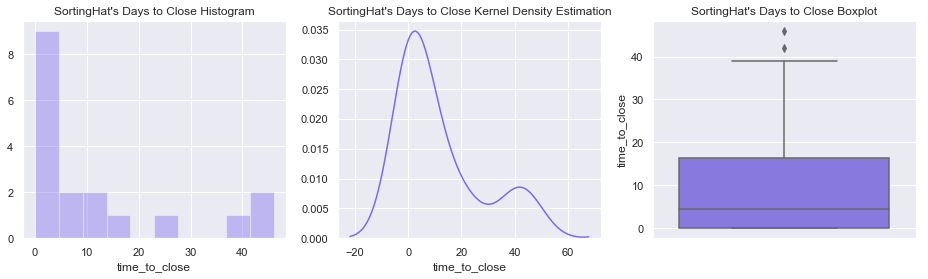

In [42]:
##creating figure with 3 columns in it
fig, axs = plt.subplots(ncols=3, figsize = (16,4))
##specifying first column content(histogram)
sns.distplot(sortinghat_times_to_close, bins = 10, kde = False, color='mediumslateblue',ax=axs[0])
##specifying second column content(Kernel Density Estimation)
sns.distplot(sortinghat_times_to_close, hist = False, color='mediumslateblue',ax=axs[1])
##specifying third column content(boxplot)
sns.boxplot(sortinghat_times_to_close,ax=axs[2],orient = "v", color = 'mediumslateblue')

##Setting plots' titles
axs[0].set_title("SortingHat's Days to Close Histogram")
axs[1].set_title("SortingHat's Days to Close Kernel Density Estimation")
axs[2].set_title("SortingHat's Days to Close Boxplot")

The histogram is showing that 15 out of the 18 issues raised for the SortingHat's repo, were closed somewhere between 0 and 25 days approximately after their creation. The KDE(kernel density estimation) is showing that the distribution is slightly skewed to right (lesser than the combined repos' one). Finally, the boxplot is showing that almost 100% of issues were solved somewhere between 0 and 39 days days approximately, so issues which took more than 39 days, can be considered as atypical and in this case there are just 2 values of this kind

<h3><a id="#kibiter" style="color:black;">Kibiter repo</a></h3>

In [39]:
##selecting just kibiter's issues
kibiter_issues = last_year_closed_issues[last_year_closed_issues['repo'] == 'https://github.com/grimoirelab/kibiter']
kibiter_times_to_close = kibiter_issues['time_to_close']

In [40]:
kibiter_issues.shape

(5, 8)

Text(0.5, 1.0, "Kibiter's Days to Close Boxplot")

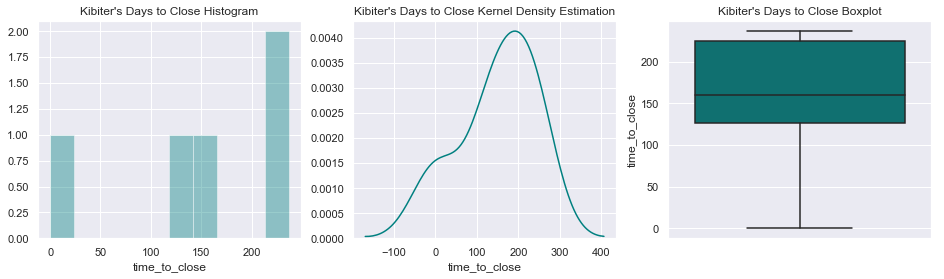

In [41]:
##creating figure with 3 columns in it
fig, axs = plt.subplots(ncols=3, figsize = (16,4))
##specifying first column content(histogram)
sns.distplot(kibiter_times_to_close, bins = 10, kde = False, color='Teal',ax=axs[0])
##specifying second column content(Kernel Density Estimation)
sns.distplot(kibiter_times_to_close, hist = False, color='Teal',ax=axs[1])
##specifying third column content(boxplot)
sns.boxplot(kibiter_times_to_close,ax=axs[2],orient = "v", color = 'Teal')

##Setting plots' titles
axs[0].set_title("Kibiter's Days to Close Histogram")
axs[1].set_title("Kibiter's Days to Close Kernel Density Estimation")
axs[2].set_title("Kibiter's Days to Close Boxplot")

The histogram is showing that 4 out of the 5 issues raised for the kibiter repo, were open for more than 100 days before being closed. The KDE(kernel density estimation) is showing that the distribution is slightly skewed to the left. Finally, the boxplot is showing that 100% of issues were solved somewhere between 0 and 240 days approximately, and in this case, there are no atypical records due to the high time-to-close variability between the 5 issues raised for kibiter. For this repository, just 5 issues were raised (a really low number compared to the other 2), so having 80% (4 issues) of the issues' time to close higher than 100 days, the whole distribution will be biased toward these high numbers

<h2><a id = "conclusions" style="color:black;">Conclusions</a></h2>

When we analyzed the three repositories, we noticed that time to close for issues where somewhere between 0 and 47 most of the time, with a few issues which took more than that (outliers). Nevertheless, when we analyzed individual repositories, we could notice that the kibiter repository was the one with the highest days-to-close with 4 out of the 5 issues raised taking more than 100 days for being closed